# ISS-VSE CA1

In [222]:
import os
import random as rand
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import imgaug as ia
from imgaug import augmenters as iaa

from CA1_Yolo import *
from voc import *
import xml.etree.ElementTree as ET
from keras.utils import Sequence

### Read all image and VOC dataset

In [223]:
def read_annotation_files(image_dir, annnotation_dir):
    all_annotations = []
    labels = {}
    for anno in sorted(os.listdir(annnotation_dir)):
        img = {'object':[]}
        try:
            xml_tree = ET.parse(annnotation_dir + anno)
        except Exception as ex:
            print(ex)
            print(f'Error parsing annotation xml: {annnotation_dir + anno}')
            continue
        for elem in xml_tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = image_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag:
                obj = {}
                for attribute in list(elem):
                    if 'name' in attribute.tag:
                        obj['name'] = attribute.text
                        if obj['name'] in labels:
                            labels[obj['name']] += 1
                        else:
                            labels[obj['name']] = 1
                        img['object'] += [obj]
                    if 'bndbox' in attribute.tag:
                        for dim in list(attribute):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        if len(img['object']) > 0:
            bb_list = []
            for obj in img['object']:
                bb_list.append(ia.BoundingBox(x1=obj['xmin'], y1=obj['ymin'], x2=obj['xmax'], y2=obj['ymax'], label=obj['name']))
            img['bbs'] = ia.BoundingBoxesOnImage(bb_list, shape=(img['width'], img['height']))
            all_annotations += [img]
    return all_annotations, labels

In [224]:
#Reference https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug
class DataGenerator(Sequence):
    '''Generate data with augmentations using Keras Util Sequence API
        Required Methods:
        def __init__(self)
        def __len__(self)
        def on_epoch_end(self)
        def __getitem__(self)'''

    def __init__(self, image_path, labels, anchors, batch_size=32, image_dims=(416, 416, 3), shuffle=False, augment=True):
        self.image_path=image_path
        self.labels=labels
        self.anchors=anchors
        self.batch_size=batch_size
        self.image_dims=image_dims
        self.shuffle=shuffle
        self.augment=augment

        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_path)/self.batch_size))
    
    def on_epoch_end(self):
        '''Update index after each epoch'''
        self.index = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.index)
    
    def augment_with_bb(self, images, boundingbox):
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.05*255),
            iaa.Affine(translate_px={"x": (1, 5)})
        ])
        return seq(images=images, bounding_boxes=boundingbox)
    
    def __getitems__(self, index):
        pass

In [225]:
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
train_ints, labels = read_annotation_files(trainimgfolder, trainannotatefolder)
labels_unqiue = labels.keys()

In [226]:
train_ints[0]

{'object': [{'name': 'car',
   'xmin': 212,
   'ymin': 403,
   'xmax': 485,
   'ymax': 499},
  {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
  {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
  {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
  {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
 'filename': '../data/image/b001.jpg',
 'width': 1280,
 'height': 720,
 'bbs': BoundingBoxesOnImage([BoundingBox(x1=212.0000, y1=403.0000, x2=485.0000, y2=499.0000, label=car), BoundingBox(x1=550.0000, y1=416.0000, x2=629.0000, y2=446.0000, label=car), BoundingBox(x1=634.0000, y1=413.0000, x2=721.0000, y2=449.0000, label=car), BoundingBox(x1=718.0000, y1=408.0000, x2=896.0000, y2=451.0000, label=car), BoundingBox(x1=1157.0000, y1=357.0000, x2=1280.0000, y2=526.0000, label=car)], shape=(1280, 720))}

In [227]:
# seq = iaa.Sequential([
#     iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
#     iaa.Affine(
#         translate_px={"x": 40, "y": 60},
#         scale=(0.5, 0.7)
#     ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
# ])

seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x": (1, 5)})
])

In [253]:
# imgs = [] 
# imgs.append(cv2.imread(train_ints[0]['filename']))
# imgs.append(cv2.imread(train_ints[1]['filename']))
img = cv2.imread(train_ints[0]['filename'])
img_aug, bbs_aug = seq(image=img, bounding_boxes=train_ints[0]['bbs'])

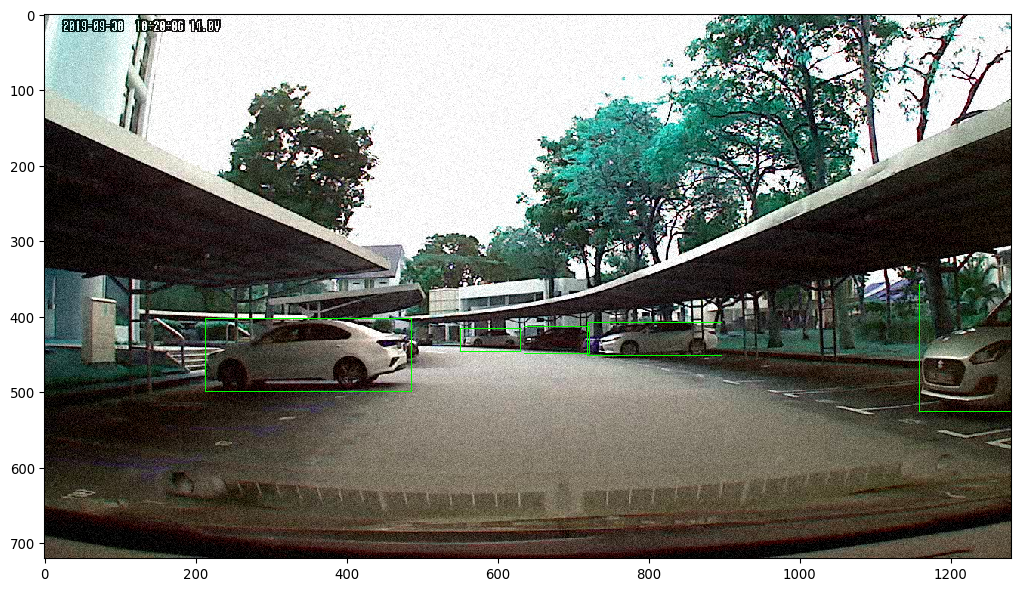

In [254]:
ia.imshow(bbs_aug.draw_on_image(img_aug))


In [266]:
class BoundingBox:
    '''Bounding Box definition'''
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin=xmin
        self.ymin=ymin
        self.xmax=xmax
        self.ymax=ymax
        self.c=c
        self.classes=classes
        self.label = None
        self.score = None
    def get_label(self):
        if self.label == None:
            self.label = np.argmax(self.classes)
        return self.label
    def get_score(self):
        if self.score == None:
            self.score = self.classes[self.get_label()]
        return self.score
def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

def boundbox_iou(bx1, bx2):
    intsec_w = interval_overlap([bx1.xmin, bx2.xmax], [bx2.xmin, bx2.xmax])
    intsec_h = interval_overlap([bx1.ymin, bx2.ymax], [bx2.ymin, bx2.ymax])
    intsec = intsec_w * intsec_h
    w1, h1 = bx1.xmax-bx1.xmin, bx1.ymax-bx1.ymin
    w2, h2 = bx2.xmax-bx2.xmin, bx2.ymax-bx2.ymin
    union = w1*h1 + w2*h2 - intsec
    return float(intsec)/union

In [255]:
bbs_aug.bounding_boxes

[BoundingBox(x1=213.0000, y1=403.0000, x2=486.0000, y2=499.0000, label=car),
 BoundingBox(x1=551.0000, y1=416.0000, x2=630.0000, y2=446.0000, label=car),
 BoundingBox(x1=635.0000, y1=413.0000, x2=722.0000, y2=449.0000, label=car),
 BoundingBox(x1=719.0000, y1=408.0000, x2=897.0000, y2=451.0000, label=car),
 BoundingBox(x1=1158.0000, y1=357.0000, x2=1281.0000, y2=526.0000, label=car)]

In [257]:
bbs_aug.bounding_boxes[1].x1

551.0

In [258]:
iou = bbs_aug.bounding_boxes[0].iou(bbs_aug.bounding_boxes[1])
print(iou)

0.0


In [267]:
anchors = fulltest
achs = []
for a in anchors:
    achs += [a.xmax, a.ymax]

AttributeError: 'tuple' object has no attribute 'xmax'

In [265]:
for bb in bbs_aug.bounding_boxes:
    max_anchor = None
    max_index = -1
    max_iou = -1
    for i in range(len(anchors)):
        ach = anchors[i]
        iou = bb.iou(ach)

AttributeError: 'tuple' object has no attribute 'x1'

In [193]:
def calculate_iou(anno, centroids):
    anno_width, anno_height = anno
    iou_list = []
    anno_area = anno_width * anno_height
    for cent in centroids:
        cent_width, cent_height = cent
        if cent_width <= anno_width and cent_height >= anno_height:
            iou = cent_width * anno_height / (anno_area + cent_width * (cent_height - anno_height))
        elif cent_width >= anno_width and cent_height >= anno_height:
            iou = anno_area / (cent_width * cent_height)
        elif cent_width >= anno_width and cent_height <= anno_height:
            iou = anno_width * cent_height / (anno_area + (cent_width - anno_width) * cent_height)
        else:
            iou = (cent_width * cent_height) / anno_area
        iou_list.append(iou)
    return np.array(iou_list)

In [194]:
annotations_dim = []
num_anchors = 9
for anno in train_ints:
    for obj in anno['object']:
        rel_width = (float(obj['xmax']) - float(obj['xmin'])) / anno['width']
        rel_height = (float(obj['ymax']) - float(obj['ymin'])) / anno['height']
        annotations_dim.append(tuple(map(float,(rel_width, rel_height))))


anno_arr = np.array(annotations_dim)
curr_assign_centroids = np.zeros(anno_arr.shape[0])
curr_distances = np.zeros((anno_arr.shape[0], num_anchors))

In [195]:
indexes = [rand.randrange(anno_arr.shape[0]) for anchor in range(num_anchors)]
sample_centroids = anno_arr[indexes]
final = sample_centroids.copy()
iterations = 0
while True:
    iterations += 1
    distances = []
    for idx in range(anno_arr.shape[0]):
        distance = 1 - calculate_iou(anno_arr[idx], sample_centroids)
        distances.append(distance)
    distances_arr = np.array(distances)
    print(f'iter: {iterations} distances: {np.sum(np.abs(curr_distances-distances_arr))}')
    assign_centroids = np.argmin(distances_arr, axis=1)
    if (assign_centroids == curr_assign_centroids).all():
        final = sample_centroids
        break
    centroid_sums = np.zeros((num_anchors, anno_arr.shape[1]), np.float)
    for idx in range(anno_arr.shape[0]):
        centroid_sums[assign_centroids[idx]] += anno_arr[idx]
    for idx in range(num_anchors):
        sample_centroids[idx] = centroid_sums[idx] / (np.sum(assign_centroids==idx) + 1e-6)
    curr_assign_centroids = assign_centroids.copy()
    curr_distances = distances_arr.copy()

iter: 1 distances: 1717.961512672886
iter: 2 distances: 139.36074457510037
iter: 3 distances: 80.42240625123894
iter: 4 distances: 55.481962780529756
iter: 5 distances: 28.761509934440838
iter: 6 distances: 27.09078817935412
iter: 7 distances: 29.90822274701148
iter: 8 distances: 30.163765514273017
iter: 9 distances: 15.626695430278122
iter: 10 distances: 10.585048133784433
iter: 11 distances: 4.062633749973301
iter: 12 distances: 1.7678310516938147


In [196]:
def print_anchors(centroids):
    out_string = ''

    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices:
        out_string += str(int(anchors[i,0]*416)) + ',' + str(int(anchors[i,1]*416)) + ', '
            
    print(out_string[:-2])
print_anchors(final)

28,20, 38,30, 40,62, 57,105, 57,39, 75,53, 94,76, 102,114, 114,36


In [205]:
test = final
test = test[test[:,0].argsort()]

In [220]:
fulltest=[]
for t in test:
    fulltest.append(((int(t[0]*416)),(int(t[1]*416))))

In [259]:
fulltest

[(28, 20),
 (38, 30),
 (40, 62),
 (57, 105),
 (57, 39),
 (75, 53),
 (94, 76),
 (102, 114),
 (114, 36)]

In [3]:
def read_voc(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
    return filename, list_with_all_boxes

In [17]:
# trainimgfolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_annotated_416x416\\'
# trainannotatefolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_raw_416x416\\'
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
cache = 'D:\Workspace\GitHub\ISS-VSE-2019-09-23-IS1FT-CA1\data\cached'
labels = ['car','bus']
train_ints, train_labels = parse_voc_annotation(trainannotatefolder, trainimgfolder, cache, labels)

In [18]:
max_box_per_image = max([len(inst['object']) for inst in (train_ints)])
max_box_per_image

5

In [16]:
ann = os.listdir(trainannotatefolder)
ann[0]

'b001.xml'

In [56]:
tree = ET.parse(trainannotatefolder+ann[4])

In [57]:
tree

In [58]:
seen_labels = {}
img = {'object':[]}
for elem in tree.iter():
    if 'filename' in elem.tag:
        img['filename'] = trainimgfolder + elem.text
    if 'width' in elem.tag:
        img['width'] = int(elem.text)
    if 'height' in elem.tag:
        img['height'] = int(elem.text)
    if 'object' in elem.tag or 'part' in elem.tag:
        obj = {}

        for attr in list(elem):
            if 'name' in attr.tag:
                obj['name'] = attr.text

                if obj['name'] in seen_labels:
                    seen_labels[obj['name']] += 1
                else:
                    seen_labels[obj['name']] = 1

                if len(labels) > 0 and obj['name'] not in labels:
                    break
                else:
                    img['object'] += [obj]

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        obj['xmin'] = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        obj['ymin'] = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        obj['xmax'] = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        obj['ymax'] = int(round(float(dim.text)))

In [59]:
seen_labels

{'car': 5}

In [60]:
img

{'object': [{'name': 'car',
   'xmin': 109,
   'ymin': 399,
   'xmax': 448,
   'ymax': 524},
  {'name': 'car', 'xmin': 561, 'ymin': 418, 'xmax': 647, 'ymax': 443},
  {'name': 'car', 'xmin': 650, 'ymin': 417, 'xmax': 743, 'ymax': 448},
  {'name': 'car', 'xmin': 769, 'ymin': 405, 'xmax': 943, 'ymax': 473},
  {'name': 'car', 'xmin': 435, 'ymin': 405, 'xmax': 499, 'ymax': 477}],
 'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b005.jpg',
 'width': 1280,
 'height': 720}

In [30]:
TESt = img.copy()

In [31]:
TESt += [img]

TypeError: unsupported operand type(s) for +=: 'dict' and 'list'

In [34]:
allinst = []
allinst += [img]
allinst += [img]

In [35]:
allinst

[{'object': [{'name': 'car',
    'xmin': 212,
    'ymin': 403,
    'xmax': 485,
    'ymax': 499},
   {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
   {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
   {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
   {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
  'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b001.jpg',
  'width': 1280,
  'height': 720},
 {'object': [{'name': 'car',
    'xmin': 212,
    'ymin': 403,
    'xmax': 485,
    'ymax': 499},
   {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
   {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
   {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
   {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
  'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b001.jpg',
  '